# 09 - Spectral gap 
In this tutorial, we will demonstrate how to improve the design of seismic surveys by minimizing the SG ratio using simulate annealing with a given mask. This enables the generation of a two-dimensional seismic subsampling mask w/o the need for expensively wavefield reconstruction. 
This tutorial is divided into two sections. 

1. Improve seismic survey design by minimizing the SG ratio of a given mask
2. Evaluate masks using a single frequency slice from a 2D synthetic Compass dataset.

In [5]:
import Pkg; Pkg.add("SeisJOLI")


   Updating registry at `~/.julia/registries/General`


┌ Warning: could not download https://pkg.julialang.org/registries
└ @ Pkg.Types /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/Pkg/src/Types.jl:951
   Updating registry at `~/.julia/registries/SLIMregistryJL`
   Updating git-repo `https://github.com/slimgroup/SLIMregistryJL.git`


  Resolving package versions...


    Cloning [1749d201-7e2c-4f32-afd0-28b1f357fcf8] SeisJOLI from https://GitHub.com/slimgroup/SeisJOLI.jl.git


  Installed SeisJOLI ─ v0.7.0
Updating `~/.julia/environments/v1.5/Project.toml`
  [1749d201] + SeisJOLI v0.7.0
Updating `~/.julia/environments/v1.5/Manifest.toml`
  [1749d201] + SeisJOLI v0.7.0


In [7]:
import Pkg; Pkg.add("Arpack")

  Resolving package versions...
Updating `~/.julia/environments/v1.5/Project.toml`
  [7d9fca2a] + Arpack v0.4.0
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


In [9]:
using JLD, JOLI, SeisJOLI, PyPlot, LinearAlgebra, Arpack
data = load("../data/wavefieldreconstruction/Data.jld")

LoadError: [91mArgumentError: No file exists at given path: ../data/wavefieldreconstruction/Data.jld[39m

We generate a mask in two ways, which serves as the initial mask that will be improved by minimizing the SG ratio.

1. Uniform random subsampling
2. Optimal jittered subsampling

In [12]:
export Subsampling_1D
###### define the subsampling function 
using Random
# uniform subsampling % white noise subsampling
function Uniform_subsample(ns::Int64,p::Int64) 
    ratio = 1/p;
    Num = Int(round(ns*ratio));
	rand_locs = randperm(ns);
    selected_locs = rand_locs[1:Num];
    return sort(selected_locs)
end

#Optimal jittered subsampling %kind of blue noise subsampling
function Optimal_Jittered_subsample(ns::Int64, p::Int64)
    b = collect(1:p)
    ind = []
    for i = 1:Int(round(ns/p))
        push!(ind,rand(b)+(i-1)*p)
    end
    return ind
end

function Subsampling_1D(ns::Int64, p::Int64; SubMethod = "Optimal_Jittered")
    #Period: Period subsampling
    #Random: Uniform random subsampling (White noise subsampling)
    #Optimal_Jittered: Optimal Jittered subsampling (default)
    # ns: the number of receivers
    # p=4 --> 75 % subsampling
    # p=2 --> 50 % subsampling
    SubMethod == "Random" && return Uniform_subsample(ns,p)   
    return Optimal_Jittered_subsample(ns, p)
end

Subsampling_1D (generic function with 1 method)

We set the number of receivers and sources are equal. And set the subsampling ratio = $33 \%$ to obtain our initial mask.

In [13]:
# square 2D case: # of sources = # of receivers
ns = 300 #number of sources
nr = 300 #number of receivers
p = 3    #subsampling ratio = 1/p
#default is optimal jittered subsampling
initial_idx = Subsampling_1D(ns, p); # Optimal jittered subsampling
#initial_idx = Subsampling_1D(ns, p; SubMethod="Random");  # Uniform random subsampling

We begin by plotting the subsampling mask in source-receiver domain.

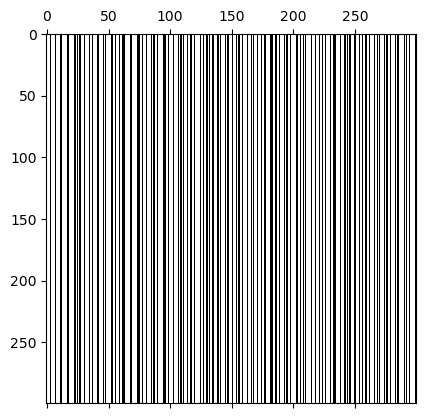

(Figure(PyObject <Figure size 640x480 with 1 Axes>), PyObject <matplotlib.image.AxesImage object at 0x141701580>)

In [14]:
# mask in the source-receiver domain
SR_Mask = zeros(ns,nr);
SR_Mask[:,initial_idx] .= 1;

#plot SR-mask
figure(),spy(SR_Mask)

Following that, we plot the initial subsampling mask in the midpoint-offset domain and calculate the SG ratio in this domain, as this is the domain in which the wavefield recovery will be implemented via matrix completion.

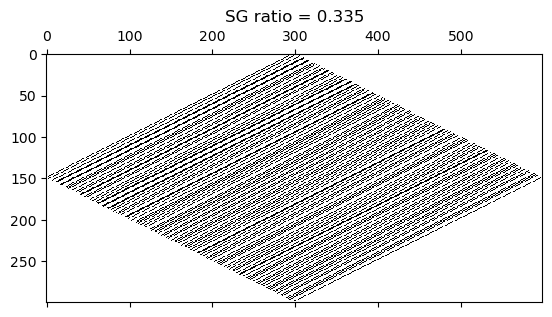

PyObject Text(0.5, 1.0954946983273597, 'SG ratio = 0.335')

In [16]:
###### Calculate the spectral gap ratio
function calculate_SGR(Mask)
    #Input: the mask in the reconstructed domain
    #Output: the spectral gap ratio for the input mask
	Z = svds(Mask, nsv = 2);	
    return Z[1].S[2]/Z[1].S[1]
end
# transfer the mask to the midpoint-offset domain
SR = joSRtoCMO(ns,nr,DDT=Float64);
MO_Mask = reshape(SR*vec(SR_Mask), ns,2*nr-1);

#plot MO-mask
figure(),spy(MO_Mask);
title(string("SG ratio = ", string(round(calculate_SGR(MO_Mask), digits=3))))

The initial mask is then improved by minimizing the SG ratio w/ simulate annealing.

In [17]:
export Opt_SpectralRatio_SA
# return SG Ratio
function Spectral_GapR(nR::Int64,locs::Vector)
    # construct mask
    nC = nR;
    Mask = zeros(nC,nR);
    Mask[:,locs] .= 1;
    # Transfer data from SR-> MO domain 
    SR = joSRtoCMO(nC,nR,DDT=Float64);
    RecMask = reshape(SR*vec(Mask),nC,2*nR-1);
    #return SG Ratio
    return calculate_SGR(RecMask)
end

###### neighbor perturb
function sample_neighbour(rec::Vector, Num::Int64, Max_loc::Int64; Max_Flag = true, MaxGap = 5, neightbor_range = 3)
    #rec: the subsampled locations
    #Num: the perturb point# of subsampled locations
    #Max_loc: the number of receivers
    #MaxGap: contral the gap between neighbor subsampled locations(used for constraints)
    #neighbor_range: control the perturb range to replace the subsampled locations

    #the number of all 
    n = length(rec);

    #random choose the perturb locations
    A = sortperm(randn(length(rec)));
    Perturb_rec = rec[A[1:Num]];

    #constructed perturbed area based on selected locations and neightbor range
    Perturb_range = Perturb_rec;
    for i = 1: neightbor_range
        Perturb_range = hcat(Perturb_rec .-i, Perturb_range, Perturb_rec .+i);
    end
    # range constraint especially for the edge
    Perturb_range[findall(x-> x.<=0, Perturb_range)] .= 1
    Perturb_range[findall(x-> x.>=Max_loc, Perturb_range)] .= Max_loc

    # replace range and remove repeated locations
    new_rec = copy(rec);
    new_rec[A[1:Num]] .= Perturb_range[CartesianIndex.(Tuple.(eachrow(hcat(1:Num,rand(1:2*neightbor_range+1,Num)))))];

    if length(unique(new_rec)) < n 
		while n != length(unique(new_rec))
            push!(new_rec,rand(1:Max_loc));
      end
	end

    # check constraints 
    if maximum(diff(new_rec))>MaxGap ? false : true
        return sort(unique(new_rec))
    else
        sample_neighbour(rec, Num, Max_loc; Max_Flag = Max_Flag, MaxGap = MaxGap)
    end
end


function Opt_SpectralRatio_SA(nR::Int64, locs1::Vector; Max_Gap = 1)
    #Input: nR: number of sources
    #       locs1: given locations (Uniform random or optimal jittered)
    #Output:best_locs: the improved locations
    #       best_sgr[1]: the initial SG ratio
    #       best_sgr[end]: the output SG ratio
    #set the Maximum gap of the new mask same as the maximum gap of the given mask
	if Max_Gap == 1
		Max_Gap = maximum(diff(locs1));
	end
	
	best_locs = locs1;

	# calculate the evaluation (SG ratio)
	cur_sgr = Spectral_GapR(nR, locs1)
	best_sgr = [cur_sgr];

    # set the probability used to control the moves
	function prob(n, res)
	    return exp(-res/(95f-2 * (70f-2)^n))
	end

	max_itr = 4000 #iteration numbers
    Num = 3  #perturb # of subsampled locations
	prob_hist = [];
	T = [];
	sg = [];
	for itr in range(1, max_itr, step=1)
        # sample neighbour to get the new location and calculate the SG ratio
	    locs =  sample_neighbour(best_locs, Num, nR; MaxGap=Max_Gap);
	    cur_sgr = Spectral_GapR(nR, locs);
        # if better, move to the new locations
	    if cur_sgr < best_sgr[end]
            push!(best_sgr, cur_sgr)
            push!(prob_hist, 1)
            best_locs = locs
        else #else use the probability to decide move or not
            p = prob(itr, cur_sgr-best_sgr[end])
            push!(prob_hist, p)
            push!(best_sgr, best_sgr[end]) 
            if rand() < p
                best_locs = locs;
                push!(best_sgr, cur_sgr)   
            end
	    end
	end
    # return the new locations, the input SG ratio and the output SG ratio
	return best_locs, best_sgr[1], best_sgr[end];
end

Opt_SpectralRatio_SA (generic function with 1 method)

In [18]:
#improve the SG ratio of the given mask by using proposed simulated annealing method
final_idx, initial_SGR, final_SGR = Opt_SpectralRatio_SA(ns, initial_idx);
println("Improved subsampled locations:")
println(final_idx)
println(string("Initial SG ratio:",string(round(initial_SGR,digits=3))))
println(string("Output SG ratio:",string(round(final_SGR,digits=3))))

Improved subsampled locations:
Any[1, 2, 5, 6, 11, 16, 21, 23, 28, 33, 38, 43, 45, 48, 53, 58, 62, 66, 69, 74, 76, 77, 82, 85, 89, 91, 96, 100, 102, 104, 106, 107, 108, 112, 113, 116, 119, 122, 125, 130, 131, 132, 135, 137, 141, 144, 145, 146, 147, 149, 151, 152, 153, 156, 158, 160, 162, 165, 166, 167, 168, 171, 176, 178, 182, 184, 185, 186, 189, 192, 193, 198, 199, 201, 205, 206, 211, 216, 220, 225, 228, 229, 233, 236, 239, 244, 249, 253, 257, 262, 267, 271, 276, 281, 285, 288, 293, 297, 299, 300]
Initial SG ratio:0.335
Output SG ratio:0.195


We discovered that the proposed strategy could successfully improve the SG ratio of a given mask based on the results. Additionally, we plot the improved mask in the domain of the source-receiver domain:

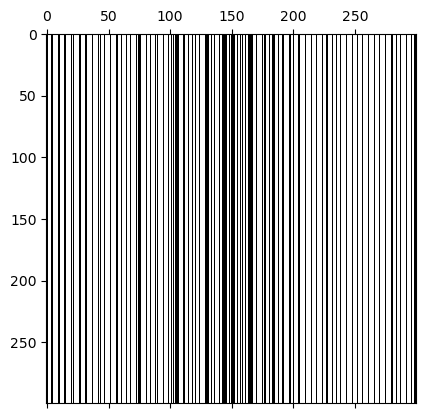

(Figure(PyObject <Figure size 640x480 with 1 Axes>), PyObject <matplotlib.image.AxesImage object at 0x1280163a0>)

In [19]:
# mask in the source-receiver domain
SR_Mask_new = zeros(ns,nr);
SR_Mask_new[:,final_idx] .= 1;

#plot SR-mask
figure(),spy(SR_Mask_new)

Following that, we plot the initial subsampling mask in the midpoint-offset domain and calculate the SG ratio in this domain.

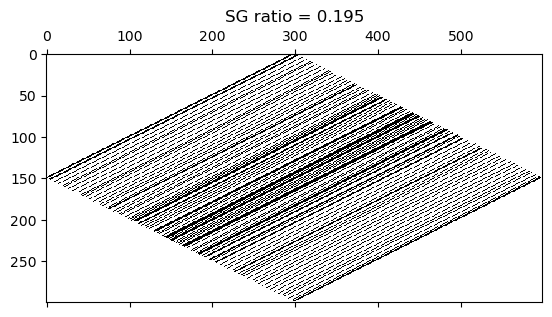

PyObject Text(0.5, 1.0954946983273597, 'SG ratio = 0.195')

In [24]:
# transfer the mask to the midpoint-offset domain
MO_Mask_new = reshape(SR*vec(SR_Mask_new), ns,2*nr-1);

#plot MO-mask
figure(),spy(MO_Mask_new);
title(string("SG ratio = ", string(round(calculate_SGR(MO_Mask_new), digits=3))))

After that, we apply both the initial and modified masks to a 2D frequency slice created from a synthetic Compass dataset. There are $300$ sources and receivers in this dataset. Sources and receivers have a sample interval of $12.5 $m. And the time sampling interval is $0.002$ seconds with a total of $1024$ samples taken along the time coordinate. We demonstrate a frequency slice ($43.5$ Hz) in this section. We begin by displaying the ground truth data, followed by the observed data using two distinct subsampling masks.

In [25]:
# plot the observed data by using the initial Mask
using Statistics
perc = 98
a =  quantile(real.(vec(data["Freq"][1,:,:])), perc/100);
nR = 300;
nC = 300;
nGrid = 12.5;
figure(figsize=(20,10))
subplot(1,3,1)
imshow(real.(data["Freq"][1,:,:]),cmap="seismic", interpolation = "none",aspect=1, extent=[1,nR,nC,1].*nGrid*1e-3, vmin = -a, vmax = a);
xlabel("Sources [Km]"); ylabel("Receiver [Km]");title("Ground truth")

Observed_data1 = zeros(Complex{Float32}, size(data["Freq"][1,:,:]));
Observed_data1[:,initial_idx] .= data["Freq"][1,:,initial_idx]
subplot(1,3,2)
imshow(real.(Observed_data1),cmap="seismic", interpolation = "none",aspect=1, extent=[1,nR,nC,1].*nGrid*1e-3, vmin = -a, vmax = a);
xlabel("Sources [Km]"); ylabel("Receiver [Km]");title("Observed data w/ initial mask")

Observed_data2 = zeros(Complex{Float32}, size(data["Freq"][1,:,:]));
Observed_data2[:,final_idx] .= data["Freq"][1,:,final_idx]
subplot(1,3,3)
imshow(real.(Observed_data2),cmap="seismic", interpolation = "none",aspect=1, extent=[1,nR,nC,1].*nGrid*1e-3, vmin = -a, vmax = a);
xlabel("Sources [Km]"); ylabel("Receiver [Km]");title("Observed data w/ final mask")

LoadError: [91mUndefVarError: data not defined[39m

We exploit the low rank matrix completion to reconstruct these two subsampled data and compare the results by using differences and SNRs. We set all the parameters are exactly same with each other and all of these low rank factors are initialized by random matrix. 

In [28]:
import Pkg; Pkg.add("GenSPGL")

  Resolving package versions...


    Cloning [46767539-6b09-4d43-90af-09e8ecbe3fb9] GenSPGL from https://GitHub.com/slimgroup/GenSPGL.jl.git


    Fetching: [=======

Fetching: [========================================>]  100.0 %Fetching: [=========>                               ]  21.6 %                         ]  36.7 %Fetching: [==========================>              ]  62.9 %Fetching: [============================>            ]  68.1 %Fetching: [============================>            ]  68.8 %Fetching: [============================>            ]  68.9 %Fetching: [============================>            ]  69.1 %Fetching: [============================>            ]  69.6 %Fetching: [=============================>           ]  71.3 %>     ]  86.4 %

  Installed GenSPGL ─ v0.7.2
Updating `~/.julia/environments/v1.5/Project.toml`
  [46767539] + GenSPGL v0.7.2
Updating `~/.julia/environments/v1.5/Manifest.toml`
  [46767539] + GenSPGL v0.7.2


In [26]:
using JOLI, GenSPGL, SeisJOLI, Arpack, LinearAlgebra, JLD, Random
function UnweightedLR(data, ind, Num)
	rng = MersenneTwister(5)
	
	a = 1;
	D = data[a,:,:];
	nm = size(D);
	nR = nm[2];
	nC = nm[1];

	# Restriction operator
	R1 = joRestriction(nR,ind[:],DDT=Complex{Float32});
	R2 = joKron(R1,joDirac(nR, DDT=Complex{Float32}));

	# Source-receiver to midpoint-offset transformation

	SR = joSRtoCMO(nR,nC,DDT=Complex{Float32});
	Bfun(x) = SR*R2'*R2*vec(x);
	afunT(x) = reshape(x[:],nR,2*nC-1);

	sigmafact = 1e-3;
	initfact = 1e-6;
	rank1 = 25;
	# Subsampled data

	#for Num = 1:513 
	
	    D = data[Num,:,:];
	    b = Bfun(D); 
	    b = reshape(b,nR,2*nC-1);

	    # Choose options for GenSPGL
	    opts = spgOptions(  optTol = Float32(1e-5),
		                bpTol = Float32(1e-5),
		                decTol = Float32(1e-4),
		                project = TraceNorm_project,
		                primal_norm = TraceNorm_primal,
		                dual_norm = TraceNorm_dual,
		                proxy = true,
		                ignorePErr = true,
		                iterations = 150,
		                verbosity = 1)

	    # Create Params Dict
	    params = Dict("nr"=> rank1,
		          "Ind"=> vec(b) .== 0,
		          "numr"=> nR,
		          "numc"=> 2*nC-1,
		          "funForward"=> NLfunForward,
		          "afunT"=> afunT,
		          "afun"=> afun,
		          "mode"=> 1,
		          "ls"=> 1,
		          "logical"=> 0,
		          "funPenalty"=> funLS)
        # randomly initial low rank factors L and R
	    LInit   = randn(rng,nR,rank1)+im*randn(nR,rank1);
	    RInit   = randn(rng,2*nC-1,rank1)+im*randn(2*nC-1,rank1);
	   
	    
	    xinit   = Complex{Float32}.(initfact*[vec(copy(LInit)); vec(copy(RInit))]);

	    tau     = norm(copy(xinit[:]),1);
	    sigma   = Float32(sigmafact*norm(b[:],2));
	    println(typeof(sigma))
        # implement the optimization
	    time1 = @elapsed xLS_jl, r, g, info = spgl1(NLfunForward, vec(b),
		                                        x = vec(xinit),
		                                        tau = tau,
		                                        sigma = sigma,
		                                        options = opts,
		                                        params = params);


	    xLS_jl = convert(Array{Float32,1},real(xLS_jl)) + (convert(Array{Float32,1},imag(xLS_jl)))im;

	    L_Num = params["numr"]*params["nr"];
	    L1 = xLS_jl[1:L_Num];
	    R1 = xLS_jl[L_Num+1:end];
	    L = reshape(L1,params["numr"],params["nr"]);
	    R = reshape(R1,params["numc"],params["nr"]);

        # obtain the recovery and calculate the SNR between the recovery and ground truth
	    data_recon_rand = reshape(SR'*vec(L*R'),nR,nC);

	    # Signal to noise ratio
	    SNR = -20*log10(norm(vec(D)-vec(data_recon_rand))/norm(vec(D)));
	    println("SNR = ",SNR, "dB")
    #end 
	# Return the recovery and SNR
    return data_recon_rand, SNR
	    
end

LoadError: [91mArgumentError: Package GenSPGL not found in current path:[39m
[91m- Run `import Pkg; Pkg.add("GenSPGL")` to install the GenSPGL package.[39m


In [27]:
# Reconstructed result by using the initial mask
Initial_Result = UnweightedLR(data["Freq"],Int64.(initial_idx),1)

LoadError: [91mUndefVarError: data not defined[39m

In [13]:
# Reconstructed result by using the improved mask
Final_Result = UnweightedLR(data["Freq"],Int64.(final_idx),1)

Float32
GenSPGL.jl, Rev 0.1, June, 2017


No. Rows                :179700               
No. Columns             :22475
Initial Tau             :0.02821585             
Penalty                 :funLS
Regularizer             :TraceNorm_primal
Penalty(b)              :429.70544
Optimality tol          :1.0e-5
Basis Pursuit tol       :1.0e-5
Maximum Iterations      :150
Target Objective        :0.42970544


Iter   Objective      Relative_Error  RelError  gNorm         stepG  tau
-------------------------------------------------------------------------

    0  4.2970544e+02  2.3289761e-08   9.99e-01  5.596e-01     0.0  7.6707190e+02
    1  4.2968530e+02  7.5550051e-04   9.99e-01  5.596e-01     0.0
    2  3.5797095e+02  4.7805421e-02   9.99e-01  5.329e-01    -0.3
    3  2.4834808e+02  5.0684091e-02   9.98e-01  4.509e-01    -3.0
    4  2.2627242e+02  7.6160543e-02   9.98e-01  4.736e-01     0.0
    5  1.6563147e+02  4.5156781e-02   9.97e-01  2.625e-01     0.0
    6  1.5158191e+02  1.4732871e-

  115  3.0022896e+01  5.2471861e-02   9.86e-01  1.569e-01    -0.9
  116  2.9940592e+01  1.6087057e-02   9.86e-01  1.572e-01     0.0
  117  2.9925417e+01  1.5784368e-02   9.86e-01  1.572e-01     0.0
  118  2.9508402e+01  2.4088219e-02   9.85e-01  1.570e-01     0.0
  119  2.9895069e+01  1.1559881e-01   9.86e-01  1.548e-01    -1.2
  120  2.9434299e+01  4.6378840e-02   9.85e-01  1.567e-01    -0.3
  121  2.9345898e+01  2.2724558e-02   9.85e-01  1.570e-01     0.0
  122  2.9320585e+01  1.5619833e-02   9.85e-01  1.571e-01     0.0
  123  2.9297049e+01  1.5262606e-02   9.85e-01  1.571e-01     0.0
  124  2.9262178e+01  3.9936706e-02   9.85e-01  1.569e-01     0.0
  125  2.9221626e+01  2.3953455e-02   9.85e-01  1.571e-01    -0.6
  126  2.9201273e+01  1.3971594e-02   9.85e-01  1.571e-01     0.0
  127  2.9187042e+01  1.3740840e-02   9.85e-01  1.571e-01     0.0
  128  2.8975967e+01  3.5590108e-02   9.85e-01  1.570e-01     0.0
  129  2.9033144e+01  6.7559302e-02   9.85e-01  1.567e-01    -1.5
  130  2.8

(Complex{Float32}[2.4519253f0 - 2.8216436f0im 2.2553723f0 - 2.9175916f0im … 0.031064084f0 + 0.08412989f0im 0.05795925f0 - 0.020926286f0im; 2.2392144f0 - 2.9693353f0im 2.0172424f0 - 2.6401281f0im … -0.05733467f0 + 0.09340514f0im 0.048582718f0 + 0.08652654f0im; … ; -0.082390904f0 - 0.084185824f0im 0.08775468f0 - 0.12204342f0im … 1.851982f0 - 4.150371f0im 1.6034298f0 - 4.27061f0im; -0.10530022f0 + 0.03759327f0im -0.074686475f0 - 0.07378127f0im … 1.5591519f0 - 4.261769f0im 1.7229625f0 - 4.068513f0im], 15.977087f0)

In [14]:
println(string("Initial SNR =", round(Initial_Result[2],digits = 2)," dB w/ SG ratio = ",string(round(initial_SGR,digits=3))))
println(string("Final SNR =", round(Final_Result[2],digits = 2)," dB w/ SG ratio = ",string(round(final_SGR,digits=3))))

Initial SNR =12.98 dB w/ SG ratio = 0.335
Final SNR =15.98 dB w/ SG ratio = 0.197


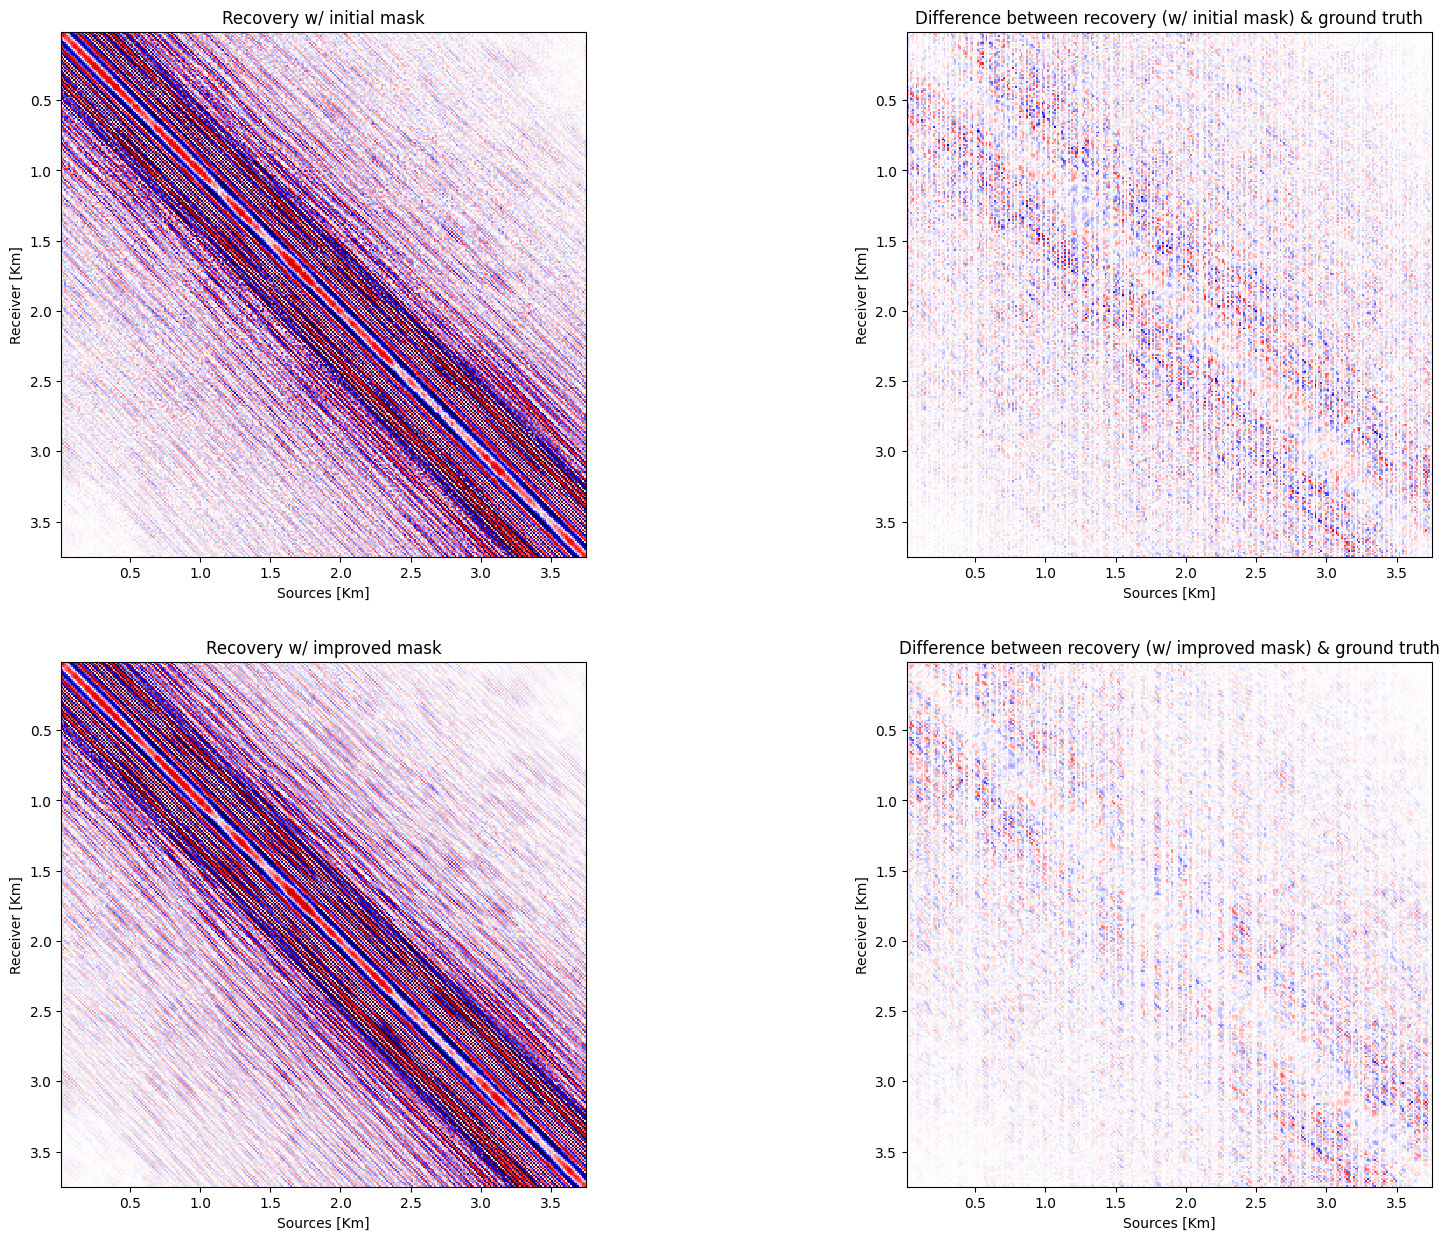

PyObject Text(0.5, 1.0, 'Difference between recovery (w/ improved mask) & ground truth')

In [15]:
# plot the recovery and difference w/ initial mask
figure(figsize=(20,15))
subplot(2,2,1)
imshow(real.(Initial_Result[1]),cmap="seismic", interpolation = "none",aspect=1, extent=[1,nR,nC,1].*nGrid*1e-3, vmin = -a, vmax = a);
xlabel("Sources [Km]"); ylabel("Receiver [Km]");title("Recovery w/ initial mask")
subplot(2,2,2)
imshow(real.(data["Freq"][1,:,:] .-Initial_Result[1]),cmap="seismic", interpolation = "none",aspect=1, extent=[1,nR,nC,1].*nGrid*1e-3, vmin = -a, vmax = a);
xlabel("Sources [Km]"); ylabel("Receiver [Km]");title("Difference between recovery (w/ initial mask) & ground truth")

subplot(2,2,3)
imshow(real.(Final_Result[1]),cmap="seismic", interpolation = "none",aspect=1, extent=[1,nR,nC,1].*nGrid*1e-3, vmin = -a, vmax = a);
xlabel("Sources [Km]"); ylabel("Receiver [Km]");title("Recovery w/ improved mask")
subplot(2,2,4)
imshow(real.(data["Freq"][1,:,:] .-Final_Result[1]),cmap="seismic", interpolation = "none",aspect=1, extent=[1,nR,nC,1].*nGrid*1e-3, vmin = -a, vmax = a);
xlabel("Sources [Km]"); ylabel("Receiver [Km]");title("Difference between recovery (w/ improved mask) & ground truth")

The results indicate that numerical experiments support the existence of a direct association between smaller SG ratio and enhanced reconstruction quality.